# Clustering Crypto

In [154]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
# import hvplot.pandas
# import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [155]:
import numpy as np

### additional imports

In [156]:
from pathlib import Path
# import holoviews.plotting.bokeh
# import holoviews as hv
# hv.extension('bokeh')
# from bokeh.plotting import show
import altair as alt
# from vega_datasets import data

### Fetching Cryptocurrency Data

In [157]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [158]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [159]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
df = pd.read_csv(file_path)

In [160]:
df.head(5)

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [161]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df = df.iloc[: , 1:]
crypto_df.head(5)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [162]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df [crypto_df['IsTrading'] == True]

In [163]:
# Keep only cryptocurrencies with a working algorithm

crypto_df.dropna(subset = ['Algorithm'], inplace = True)


In [164]:
# Remove the "IsTrading" column
crypto_df.drop('IsTrading', inplace = True, axis = 1)


In [165]:
crypto_df.isnull().sum()

CoinName             0
Algorithm            0
ProofType            0
TotalCoinsMined    459
TotalCoinSupply      0
dtype: int64

In [166]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace = True)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
4,808,SHA-256,PoW/PoS,0.000000e+00,0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [167]:
crypto_df.dtypes
# df['a'] = pd.to_numeric(df['a'],errors = 'coerce')
crypto_df['TotalCoinSupply'] = pd.to_numeric(crypto_df['TotalCoinSupply'] ,errors = 'coerce')
crypto_df.dtypes

CoinName            object
Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
dtype: object

In [168]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df [crypto_df['TotalCoinSupply'] != 0]
crypto_df.head(5)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
5,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11
7,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07
9,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07


In [169]:
# create dataframe to add later
coin_df = crypto_df.copy()

In [170]:
# Drop rows where there are 'N/A' text values
# aldready done..???

In [171]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name = crypto_df.filter(['CoinName'], axis = 1)
# df_CoinName.column = ['CoinName']
coin_name.head()

,CoinName
0,42 Coin
2,404Coin
5,EliteCoin
7,Bitcoin
9,Litecoin


In [172]:
coin_name = crypto_df

In [173]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(['CoinName'], axis = 1, inplace = True)
crypto_df.head()


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
2,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
5,X13,PoW/PoS,2.927942e+10,3.141593e+11
7,SHA-256,PoW,1.792718e+07,2.100000e+07
9,Scrypt,PoW,6.303924e+07,8.400000e+07


In [174]:
# Create dummy variables for text features
# -- delete
# test = crypto_df.copy()
# # df.dtypes[df.dtypes == 'float64'].index.tolist()
# -- end delete
# # get a list of object types
obj_columns = crypto_df.dtypes[crypto_df.dtypes == 'object'].index.tolist()
# convert text columns to dummies
crypto_df = pd.get_dummies(crypto_df, columns= obj_columns)
crypto_df.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,6.303924e+07,8.400000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
# Standardize data
# test = crypto_df.copy()
cryto_scaled = StandardScaler().fit_transform(crypto_df)
print(cryto_scaled[:1])


[[-0.09782131 -0.03965512 -0.03965258 -0.03965258 -0.03965258 -0.05612135
  -0.07949286 -0.03965258 -0.03965258 -0.05612135 -0.03965258 -0.03965258
  -0.18913582 -0.05612135 -0.03965258 -0.03965258 -0.07949286 -0.03965258
  -0.08894601 -0.06878853 -0.03965258 -0.03965258 -0.17052613 -0.03965258
  -0.03965258 -0.13856406 -0.03965258 -0.03965258 -0.06878853 -0.03965258
  -0.03965258 -0.03965258 -0.03965258 -0.06878853 -0.03965258 -0.07949286
  -0.08894601 -0.07949286 -0.03965258 -0.03965258 -0.11971303 -0.13255899
  -0.14433757 -0.03965258 -0.05612135 -0.03965258 -0.06878853 -0.17052613
  -0.03965258 -0.03965258 -0.03965258 -0.05612135 -0.18004141 -0.33998043
  -0.03965258 -0.08894601 -0.06878853 -0.05612135 -0.03965258  1.42090019
  -0.06878853 -0.03965258 -0.03965258 -0.06878853 -0.06878853 -0.03965258
  -0.03965258 -0.03965258 -0.03965258 -0.03965258 -0.03965258 -0.03965258
  -0.4108617  -0.03965258 -0.18004141 -0.03965258 -0.09751265 -0.07949286
  -0.09751265 -0.03965258 -0.03965258 

### Reducing Dimensions Using PCA

In [176]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(cryto_scaled)

In [177]:
# Create a DataFrame with the principal components data
# df_iris_pca = pd.DataFrame(
#     data=iris_pca, columns=["principal component 1", "principal component 2"]
# )
# df_iris_pca.head()
pcs_df  = pd.DataFrame(
    data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"], index = crypto_df.index
)
pcs_df.head()

,PC 1,PC 2,PC 3
0,-0.175351,-1.198256,-0.536964
2,-0.160733,-1.195831,-0.537458
5,0.443656,-1.900323,-0.614962
7,-0.260557,1.370584,0.196769
9,-0.353428,1.038882,-0.008358


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [178]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
# df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

# show(hv.render(plot))

C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



In [179]:
# altair plot
# import altair as alt
# import numpy as np
# import pandas as pd

# x = np.arange(100)
# source = pd.DataFrame({
#   'x': x,
#   'f(x)': np.sin(x / 5)
# })

alt.Chart(df_elbow).mark_line().encode(
    x='k',
    y='inertia'
)

alt.Chart(...)

Running K-Means with `k=<your best value for k here>`

In [180]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)
# Fit the model
model.fit(pcs_df)
# Predict clusters
predictions = model.predict(pcs_df)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
pcs_df["Class"] = model.labels_
pcs_df.head()

,PC 1,PC 2,PC 3,Class
0,-0.175351,-1.198256,-0.536964,0
2,-0.160733,-1.195831,-0.537458,0
5,0.443656,-1.900323,-0.614962,0
7,-0.260557,1.370584,0.196769,1
9,-0.353428,1.038882,-0.008358,1


In [181]:
# clustered_df = pd.concat ([coin_df, df_crypto_pca], join = 'outer')
# clustered_df.head()
clustered_df = coin_df.copy().dropna()

col_list = pcs_df.columns.tolist()
for columnName in col_list:
    clustered_df[columnName] = pcs_df[columnName]
clustered_df.head()


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,Class
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,-0.175351,-1.198256,-0.536964,0
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,-0.160733,-1.195831,-0.537458,0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11,0.443656,-1.900323,-0.614962,0
7,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07,-0.260557,1.370584,0.196769,1
9,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07,-0.353428,1.038882,-0.008358,1


### Visualizing Results

#### 3D-Scatter with Clusters

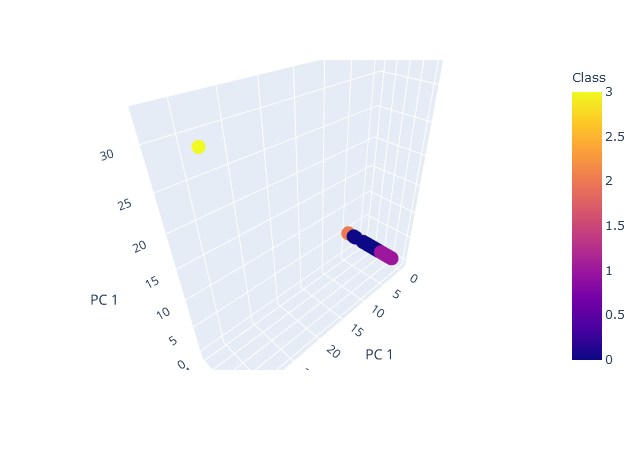

In [182]:
# Create a 3D-Scatter with the PCA data and the clusters

# fig.update_layout(legend=dict(x=0, y=1))
# fig.show()
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 1",
    color="Class",
#     symbol="class",
    hover_name="CoinName",
    hover_data=["Algorithm"],
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [183]:
# delete
# transform objects to strings.
# clustered_df.dtypes

In [184]:
# delete
# df['column'] = df['column'].astype('str') 
# change objects columns to string
# make a copy
# alt_clust_df = clustered_df.copy()
# change objects to sting (assuming all objects are strings)

# sample code
# all_btc_tokens = []
# for index, row in bitcoin_df.iterrows():
#     all_btc_tokens.extend(row['tokens'])

In [185]:
# alair
# import altair as alt
# from vega_datasets import data

# source = data.cars()

alt.Chart(clustered_df).mark_circle(size=60).encode(
    x='PC 1',
    y='PC 2',
    color='Algorithm',
    tooltip=["CoinName", "Algorithm", "TotalCoinsMined", "TotalCoinSupply"]
).interactive()

alt.Chart(...)

#### Table of Tradable Cryptocurrencies

In [186]:
# Table with tradable cryptos
# df.hvplot.table(columns=['origin', 'name', 'yr'], sortable=True, selectable=True)
col_list = ["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"]
# clustered_df.hvplot.table(columns =col_list)

In [187]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df)
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(clustered_df)
print(clustered_df.to_string())

                              CoinName               Algorithm             ProofType  TotalCoinsMined  TotalCoinSupply       PC 1      PC 2       PC 3  Class
0                              42 Coin                  Scrypt               PoW/PoS     4.199995e+01     4.200000e+01  -0.175351 -1.198256  -0.536964      0
2                              404Coin                  Scrypt               PoW/PoS     1.055185e+09     5.320000e+08  -0.160733 -1.195831  -0.537458      0
5                            EliteCoin                     X13               PoW/PoS     2.927942e+10     3.141593e+11   0.443656 -1.900323  -0.614962      0
7                              Bitcoin                 SHA-256                   PoW     1.792718e+07     2.100000e+07  -0.260557  1.370584   0.196769      1
9                             Litecoin                  Scrypt                   PoW     6.303924e+07     8.400000e+07  -0.353428  1.038882  -0.008358      1
10                                Dash              

In [188]:
# Print the total number of tradable cryptocurrencies
print (f'Total Tradable Currencies: {clustered_df["TotalCoinSupply"].sum()}')

Total Tradable Currencies: 9.223962144580946e+16


#### Scatter Plot with Tradable Cryptocurrencies

In [189]:
# Scale data to create the scatter plot
# select columns to be charted
cluster_for_chart = clustered_df.filter(['TotalCoinsMined',"TotalCoinSupply" ], axis=1)
# scale them to data 
culster_scaled_np = StandardScaler().fit_transform(cluster_for_chart)
# transform to np array to dataframe
cluster_scaled_df = pd.DataFrame(culster_scaled_np, columns = ['TotalCoinsMined',"TotalCoinSupply"])
cluster_scaled_df.head(1)

,TotalCoinsMined,TotalCoinSupply
0,-0.097821,-0.039655


In [190]:
type(culster_scaled)

numpy.ndarray

In [191]:
# delete
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
# cluster_scaled_df.hvplot.scatter(
#         x="TotalCoinsMined",
#         y="TotalCoinSupply",
#         hover_cols=["CoinName"]
#         )

In [192]:
alt.Chart(df_temp).mark_circle(size=60).encode(
    x="TotalCoinsMined",
    y='TotalCoinSupply',
#     color='indx'
#     tooltip=['indx']
).interactive()

alt.Chart(...)